<a href="https://colab.research.google.com/github/Occtoluf/image-recognition-labs/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline - модель без оптимизаций, запуск на GPU T4 бесплатной версии.

Я выбрал CIFAR-10 быстро загружается, 50k train + 10k test, модель ResNet50 из приложений Keras, батч 128, 5 эпох. Замеряем время каждой эпохи и images/sec.

In [ ]:
# BASELINE — базовый запуск без оптимизаций

import tensorflow as tf
import time
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10

# Загрузка CIFAR-10
print("Загружаем CIFAR-10...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормализация
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Простой датасет без оптимизаций
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(5000).batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset  = test_dataset.batch(128)

# Модель ResNet50
print("Создаём модель...")
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
    pooling='avg'
)
base_model.trainable = False  # замораживаем

model = models.Sequential([
    base_model,
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Замер времени обучения
print("\nЗапуск baseline-обучения (5 эпох)...")
times = []
images_per_sec = []

total_images = len(x_train)  # 50000

for epoch in range(5):
    start_time = time.time()

    history = model.fit(
        train_dataset,
        epochs=1,
        validation_data=test_dataset,
        verbose=1
    )

    epoch_time = time.time() - start_time
    times.append(epoch_time)

    img_sec = total_images / epoch_time
    images_per_sec.append(img_sec)

    print(f"Эпоха {epoch+1:2d}: {epoch_time:.1f} сек | {img_sec:.0f} img/sec")

# Итоговые результаты
avg_time = np.mean(times)
avg_speed = np.mean(images_per_sec)

print("\n" + "="*60)
print("BASELINE РЕЗУЛЬТАТЫ")
print(f"Среднее время эпохи: {avg_time:.1f} сек")
print(f"Средняя скорость:   {avg_speed:.0f} изображений/сек")
print("="*60)

# Сохраняем для сравнения в следующих ячейках
baseline_avg_time = avg_time
baseline_avg_speed = avg_speed

Загружаем CIFAR-10...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Создаём модель...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Запуск baseline-обучения (5 эпох)...
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.1723 - loss: 2.2615 - val_accuracy: 0.2908 - val_loss: 2.0017
Эпоха  1: 31.0 сек | 1613 img/sec
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2782 - loss: 2.0055 - val_accuracy: 0.3089 - val_loss: 1.9264
Эпоха  2: 5.7 сек | 8814 img/sec
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3125 - loss: 1.9258 - val_accuracy: 0.3234 - val_loss: 1.8793
Эпоха  3: 6.1 сек | 8161 img/sec
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3285 - loss: 1.8867 - val_accuracy: 0.3588 - val_loss: 1.8387
Эпоха  4: 5.7 сек | 8701 img/sec
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3428 - loss: 1.8562 - val_accuracy: 0.3533 - val_loss: 1.8365
Эпоха  5: 5.6 сек | 8899 img/sec

BASELINE РЕЗУЛЬТАТЫ
Среднее время эпохи: 10.8 сек
Средняя скорость:   7238 изображений/сек


далее начнем оптимизировать модель сравнивая с нашим базовым значением из 1 ячейки

In [ ]:
# 1.1 TFRecord — создание и сравнение скорости


import tensorflow as tf
import time
import os
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10

# ─── Если датасет ещё не загружен (на случай перезапуска) ───
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# ─── Функция для записи TFRecord (без сжатия и со сжатием) ───
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def write_tfrecord(filename, images, labels, compress=False):
    options = tf.io.TFRecordOptions(compression_type="GZIP" if compress else "")
    with tf.io.TFRecordWriter(filename, options=options) as writer:
        for img, lbl in zip(images, labels.flatten()):
            feature = {
                'image_raw': _bytes_feature(img.tobytes()),
                'label':     _int64_feature(lbl)
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

# Создаём два варианта TFRecord (сжатый и несжатый)
print("Создаём TFRecord файлы...")
write_tfrecord('train.tfrecord', x_train, y_train, compress=False)
write_tfrecord('train_compressed.tfrecord', x_train, y_train, compress=True)

# ─── Функция парсинга при чтении ───
def parse_example(example_proto):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label':     tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_raw(example['image_raw'], tf.float32)
    image = tf.reshape(image, [32, 32, 3])
    label = example['label']
    return image, label

# ─── Чтение через TFRecordDataset ───
def create_tfrecord_dataset(filename, batch_size=128):
    dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP" if "compressed" in filename else "")
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(batch_size)
    return dataset

tfrecord_ds = create_tfrecord_dataset('train.tfrecord')
tfrecord_compressed_ds = create_tfrecord_dataset('train_compressed.tfrecord')

# ─── Модель (та же, что в baseline) ───
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ─── Замер скорости для трёх вариантов ───
variants = [
    ("Baseline (from_tensor_slices)", train_dataset),
    ("TFRecord без сжатия", tfrecord_ds),
    ("TFRecord с GZIP", tfrecord_compressed_ds)
]

results = {}

for name, ds in variants:
    print(f"\nЗамер: {name}")
    times = []
    total_images = len(x_train)

    for epoch in range(3):  # 3 эпохи для стабильности
        start = time.time()
        model.fit(ds, epochs=1, verbose=0)
        t = time.time() - start
        times.append(t)
        print(f"  Эпоха {epoch+1}: {t:.1f} сек")

    avg_time = np.mean(times)
    speed = total_images / avg_time
    results[name] = (avg_time, speed)

# ─── Вывод сравнения ───
print("\n" + "="*70)
print("СРАВНЕНИЕ СКОРОСТИ ЧТЕНИЯ ДАННЫХ")
print(f"{'Вариант':<35} {'Время эпохи (с)':<18} {'Images/sec':<15} {'Прирост к baseline (%)':<20}")
print("-"*70)

baseline_time, baseline_speed = results["Baseline (from_tensor_slices)"]

for name, (t, s) in results.items():
    gain = ((baseline_speed - s) / baseline_speed * 100) if name != "Baseline (from_tensor_slices)" else 0
    print(f"{name:<35} {t:.1f} {'':<10} {s:.0f} {'':<10} {gain:+.1f}%")

Создаём TFRecord файлы...

Замер: Baseline (from_tensor_slices)
  Эпоха 1: 19.1 сек
  Эпоха 2: 4.4 сек
  Эпоха 3: 4.2 сек

Замер: TFRecord без сжатия


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


  Эпоха 1: 15.6 сек
  Эпоха 2: 6.0 сек
  Эпоха 3: 5.0 сек

Замер: TFRecord с GZIP
  Эпоха 1: 8.2 сек
  Эпоха 2: 8.2 сек
  Эпоха 3: 7.3 сек

СРАВНЕНИЕ СКОРОСТИ ЧТЕНИЯ ДАННЫХ
Вариант                             Время эпохи (с)    Images/sec      Прирост к baseline (%)
----------------------------------------------------------------------
Baseline (from_tensor_slices)       9.2            5432            +0.0%
TFRecord без сжатия                 8.9            5641            -3.8%
TFRecord с GZIP                     7.9            6324            -16.4%


1.2 оптимизация tf.data

In [ ]:
# 1.2 tf.data оптимизации — сравнение вариантов


import tensorflow as tf
import time
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

BATCH_SIZE = 128
SHUFFLE_BUFFER = 5000
EPOCHS_FOR_TEST = 3

#  Модель
def create_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False
    model = models.Sequential([base_model, layers.Dense(10, activation='softmax')])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Функции создания датасетов
def variant_1_basic():
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    return ds

def variant_2_map():
    def preprocess(img, lbl):
        return img, lbl  # уже нормализовано
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.shuffle(SHUFFLE_BUFFER).map(preprocess).batch(BATCH_SIZE)
    return ds

def variant_3_parallel_map():
    def preprocess(img, lbl):
        return img, lbl
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.shuffle(SHUFFLE_BUFFER)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds

def variant_4_prefetch():
    ds = variant_3_parallel_map()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def variant_5_full_opt():
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.cache()                                      # кэш в память
    ds = ds.shuffle(SHUFFLE_BUFFER)                      # обычный shuffle

    options = tf.data.Options()
    options.deterministic = False
    ds = ds.with_options(options)
    ds = ds.map(lambda x, y: (x, y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

variants = {
    "1. Базовый (shuffle + batch)": variant_1_basic,
    "2. + map": variant_2_map,
    "3. + parallel map": variant_3_parallel_map,
    "4. + prefetch": variant_4_prefetch,
    "5. Полная оптимизация (+cache + deterministic=False)": variant_5_full_opt
}

# Замеры
results = {}
total_images = len(x_train)

print("Замер производительности tf.data вариантов...\n")

for name, ds_func in variants.items():
    print(f"→ {name}")
    model = create_model()  # новая модель
    ds = ds_func()

    times = []
    for epoch in range(EPOCHS_FOR_TEST):
        start = time.time()
        model.fit(ds, epochs=1, verbose=0)
        t = time.time() - start
        times.append(t)
        print(f"   эпоха {epoch+1:2d}: {t:5.1f} сек")

    avg_time = np.mean(times)
    speed = total_images / avg_time
    results[name] = (avg_time, speed)

# Таблица результатов
print("\n" + "═"*80)
print(f"{'Вариант':<45} {'Время эпохи (с)':<18} {'Images/sec':<15} {'Прирост к базовому (%)':<20}")
print("─"*80)

base_time, base_speed = results["1. Базовый (shuffle + batch)"]

for name, (t, s) in results.items():
    gain = ((base_speed - s) / base_speed * 100) if name != "1. Базовый (shuffle + batch)" else 0
    print(f"{name:<45} {t:5.1f} {'':<10} {s:>5.0f} {'':<10} {gain:+6.1f}%")

print("═"*80)

Замер производительности tf.data вариантов...

→ 1. Базовый (shuffle + batch)
   эпоха  1:  17.2 сек
   эпоха  2:   4.3 сек
   эпоха  3:   4.5 сек
→ 2. + map
   эпоха  1:  17.3 сек
   эпоха  2:   4.7 сек
   эпоха  3:   4.2 сек
→ 3. + parallel map
   эпоха  1:  18.4 сек
   эпоха  2:   4.4 сек
   эпоха  3:   4.5 сек
→ 4. + prefetch
   эпоха  1:  17.9 сек
   эпоха  2:   5.0 сек
   эпоха  3:   4.5 сек
→ 5. Полная оптимизация (+cache + deterministic=False)
   эпоха  1:  18.7 сек
   эпоха  2:   4.6 сек
   эпоха  3:   4.5 сек

════════════════════════════════════════════════════════════════════════════════
Вариант                                       Время эпохи (с)    Images/sec      Прирост к базовому (%)
────────────────────────────────────────────────────────────────────────────────
1. Базовый (shuffle + batch)                    8.7             5761              +0.0%
2. + map                                        8.8             5712              +0.8%
3. + parallel map               

Изначальный вывод сделал хуже результат. Это объяснимо и ожидаемо из-за того, что у нас слишком маленький датасет и размер изображений 32х32. При оптимизации на другом датасете и с ресайзом 224х224 мы бы получили лучший результат. Каждый раз мы напрягаем CPU для доп. потоков, кеширования данных, буфферизации и подготовки батча и для shuffle, это просто не окупает затрат для маленького датасета, хотя действия все правильные и на большом датасете и лучшей системе мы бы получили релевантные значения. Должен быть прирост х2-х5 к оригинальной скорости при обучении 224х224 100к изображений, но на CIFAR-10 все затраты на оптимизацию не окупаются.
Оптимизация работает только там, где есть проблема, которую она устраняет
════════════════════════════════════════════════════════════════════════════════
Вариант                                       Время эпохи (с)    Images/sec      Прирост к базовому (%)
────────────────────────────────────────────────────────────────────────────────
1. Базовый (shuffle + batch)                    8.7             5761              +0.0%
2. + map                                        8.8             5712              +0.8%
3. + parallel map                               9.1             5488              +4.7%
4. + prefetch                                   9.1             5469              +5.1%
5. Полная оптимизация (+cache + deterministic=False)   9.3             5397              +6.3%

1.3 Кэширование данных

In [ ]:
# 1.3 Кэширование данных — в памяти vs на диске

import tensorflow as tf
import time
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

BATCH_SIZE = 128
SHUFFLE_BUFFER = 5000
EPOCHS = 5  # берём больше эпох, чтобы увидеть разницу между 1-й и остальными

# Функция создания модели (каждый раз новая)
def create_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False
    model = models.Sequential([base_model, layers.Dense(10, activation='softmax')])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Три варианта датасета
def dataset_no_cache():
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    return ds

def dataset_memory_cache():
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.cache()  # кэш в памяти (RAM)
    ds = ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    return ds

def dataset_disk_cache():
    cache_file = 'train_cache.tf-data'
    # Удаляем старый кэш, если есть
    if os.path.exists(cache_file):
        tf.io.gfile.rmtree(cache_file)
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds = ds.cache(cache_file)  # кэш на диск
    ds = ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    return ds

variants = {
    "Без кэша": dataset_no_cache,
    "Кэш в памяти": dataset_memory_cache,
    "Кэш на диск": dataset_disk_cache
}

results = {}

print("Замер кэширования (5 эпох)...\n")

for name, ds_func in variants.items():
    print(f"→ {name}")
    model = create_model()
    ds = ds_func()

    epoch_times = []
    for epoch in range(EPOCHS):
        start = time.time()
        model.fit(ds, epochs=1, verbose=0)
        t = time.time() - start
        epoch_times.append(t)
        print(f"   эпоха {epoch+1:2d}: {t:6.2f} сек")

    avg_after_first = np.mean(epoch_times[1:])
    first_epoch_time = epoch_times[0]

    results[name] = {
        'первая эпоха': first_epoch_time,
        'среднее после': avg_after_first,
        'images/sec после': len(x_train) / avg_after_first
    }

# Таблица
print("\n" + "═"*90)
print(f"{'Вариант':<20} {'Первая эпоха (с)':<18} {'Среднее после 1-й (с)':<22} {'Images/sec после':<18} {'Прирост к "без кэша" (%)':<20}")
print("─"*90)

base_after = results["Без кэша"]['среднее после']
base_speed = results["Без кэша"]['images/sec после']

for name, res in results.items():
    gain = (res['images/sec после'] - base_speed) / base_speed * 100
    print(f"{name:<20} {res['первая эпоха']:>6.2f} {'':<10} {res['среднее после']:>6.2f} {'':<10} {res['images/sec после']:>6.0f} {'':<8} {gain:+6.1f}%")

print("═"*90)

Замер кэширования (5 эпох)...

→ Без кэша
   эпоха  1:  18.12 сек
   эпоха  2:   4.26 сек
   эпоха  3:   4.47 сек
   эпоха  4:   4.12 сек
   эпоха  5:   4.14 сек
→ Кэш в памяти
   эпоха  1:  17.26 сек
   эпоха  2:   4.40 сек
   эпоха  3:   4.56 сек
   эпоха  4:   4.22 сек
   эпоха  5:   4.25 сек
→ Кэш на диск
   эпоха  1:  22.38 сек
   эпоха  2:   5.02 сек
   эпоха  3:   4.64 сек
   эпоха  4:   4.70 сек
   эпоха  5:   4.76 сек

══════════════════════════════════════════════════════════════════════════════════════════
Вариант              Первая эпоха (с)   Среднее после 1-й (с)  Images/sec после   Прирост к "без кэша" (%)
──────────────────────────────────────────────────────────────────────────────────────────
Без кэша              18.12              4.25             11773            +0.0%
Кэш в памяти          17.26              4.36             11473            -2.6%
Кэш на диск           22.38              4.78             10466           -11.1%
════════════════════════════════════

Работа с cat vs dogs 224x224x3

In [ ]:
# 1.3 Кэширование данных — в памяти vs на диске


import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import os

# Загрузка датасета cats_vs_dogs
print("Загружаем cats_vs_dogs...")
(ds_train_full, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Предобработка: resize до 224×224 + нормализация
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 64
EPOCHS = 5

# Берём подмножество для скорости эксперимента
TRAIN_LIMIT = 5000
ds_train = ds_train_full.take(TRAIN_LIMIT).map(preprocess)

# Функция создания модели
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Три варианта датасета
def dataset_no_cache():
    ds = ds_train.shuffle(1000).batch(BATCH_SIZE)
    return ds

def dataset_memory_cache():
    ds = ds_train.cache()  # кэш в памяти (RAM)
    ds = ds.shuffle(1000).batch(BATCH_SIZE)
    return ds

def dataset_disk_cache():
    cache_file = 'cats_vs_dogs_cache.tf-data'
    # Удаляем старый кэш, если есть
    if os.path.exists(cache_file):
        tf.io.gfile.rmtree(cache_file)
    ds = ds_train.cache(cache_file)  # кэш на диск
    ds = ds.shuffle(1000).batch(BATCH_SIZE)
    return ds

variants = {
    "Без кэша": dataset_no_cache,
    "Кэш в памяти": dataset_memory_cache,
    "Кэш на диск": dataset_disk_cache
}

results = {}

print("Замер кэширования на cats_vs_dogs 224×224 (5 эпох)...\n")

for name, ds_func in variants.items():
    print(f"→ {name}")
    model = create_model()
    ds = ds_func()

    epoch_times = []
    for epoch in range(EPOCHS):
        start = time.time()
        model.fit(ds, epochs=1, verbose=1)
        t = time.time() - start
        epoch_times.append(t)
        print(f"   эпоха {epoch+1:2d}: {t:6.2f} сек")

    # Среднее по эпохам 2–5 (после записи кэша)
    avg_after_first = np.mean(epoch_times[1:])
    first_epoch_time = epoch_times[0]

    results[name] = {
        'первая эпоха': first_epoch_time,
        'среднее после': avg_after_first,
        'images/sec после': TRAIN_LIMIT / avg_after_first
    }

# Таблица
print("\n" + "═"*90)
print(f"{'Вариант':<20} {'Первая эпоха (с)':<18} {'Среднее после 1-й (с)':<22} {'Images/sec после':<18} {'Прирост к "без кэша" (%)':<20}")
print("─"*90)

base_after = results["Без кэша"]['среднее после']
base_speed = results["Без кэша"]['images/sec после']

for name, res in results.items():
    gain = (res['images/sec после'] - base_speed) / base_speed * 100
    print(f"{name:<20} {res['первая эпоха']:>6.2f} {'':<10} {res['среднее после']:>6.2f} {'':<10} {res['images/sec после']:>6.0f} {'':<8} {gain:+6.1f}%")

print("═"*90)

Загружаем cats_vs_dogs...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.68NONG_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Замер кэширования на cats_vs_dogs 224×224 (5 эпох)...

→ Без кэша


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.5553 - loss: 1.5931
   эпоха  1:  22.58 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6537 - loss: 0.6293
   эпоха  2:   9.58 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8134 - loss: 0.4253
   эпоха  3:  10.26 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8650 - loss: 0.3240
   эпоха  4:  10.60 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9352 - loss: 0.1859
   эпоха  5:  10.69 сек
→ Кэш в памяти
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5399 - loss: 1.7143
   эпоха  1:  14.31 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6571 - loss: 0.6329
   эпоха  2:   7.49 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7437 - loss: 0.5070
   эпоха  3:   7.19 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8361 - loss: 0.3731
   эпоха  4:   7.35 сек
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9081 - loss: 0.2381
   эпоха  5:   7.

На датасете cats_vs_dogs с тяжёлой предобработкой (resize до 224×224) кэширование в памяти даёт значительный прирост скорости (+39.8%) после первой эпохи, тогда как кэширование на диск замедляет обучение из-за медленного дискового I/O (-25.5%).

кэш в памяти полезен, когда данные не помещаются в RAM или предобработка дорогая, а кэш на диск имеет смысл только при очень ограниченной оперативной памяти.

2.1 Автоматическая смешанная точност

In [ ]:
# 2.1 Автоматическая смешанная точность (mixed precision)
# Сравнение float32 vs mixed_float16


import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np

# Проверяем GPU
print("GPU доступен:", tf.test.is_gpu_available())
!nvidia-smi

# Загрузка датасета (берём небольшой кусок для скорости замера)
print("Загружаем cats_vs_dogs...")
(ds_train_full, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:10%]', 'train[10%:15%]'],  # ~2300 train + ~230 test
    with_info=True,
    as_supervised=True
)

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 64
EPOCHS = 5

ds_train = ds_train_full.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Функция создания модели
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  Baseline: обычный float32
print("\n=== Baseline (float32) ===")
model_fp32 = create_model()
times_fp32 = []

start_total = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    model_fp32.fit(ds_train, epochs=1, validation_data=ds_val, verbose=1)
    t = time.time() - start
    times_fp32.append(t)
    print(f"  эпоха {epoch+1}: {t:.2f} сек")

avg_fp32 = np.mean(times_fp32)
speed_fp32 = (ds_info.splits['train[:10%]'].num_examples) / avg_fp32
print(f"Среднее время эпохи: {avg_fp32:.2f} сек | {speed_fp32:.0f} img/sec")

# Mixed Precision
print("\n=== Mixed Precision (float16) ===")
tf.keras.mixed_precision.set_global_policy('mixed_float16')

model_mixed = create_model()
times_mixed = []

for epoch in range(EPOCHS):
    start = time.time()
    model_mixed.fit(ds_train, epochs=1, validation_data=ds_val, verbose=1)
    t = time.time() - start
    times_mixed.append(t)
    print(f"  эпоха {epoch+1}: {t:.2f} сек")

avg_mixed = np.mean(times_mixed)
speed_mixed = (ds_info.splits['train[:10%]'].num_examples) / avg_mixed
print(f"Среднее время эпохи: {avg_mixed:.2f} сек | {speed_mixed:.0f} img/sec")

# Сравнение
print("\n" + "═"*70)
print("СРАВНЕНИЕ MIXED PRECISION")
print(f"{'Вариант':<25} {'Среднее время эпохи (с)':<22} {'Images/sec':<15} {'Прирост скорости (%)':<20}")
print("─"*70)
gain = (speed_mixed - speed_fp32) / speed_fp32 * 100
print(f"float32 (baseline)      {avg_fp32:>6.2f} {'':<10} {speed_fp32:>6.0f} {'':<10} +0.0%")
print(f"mixed_float16           {avg_mixed:>6.2f} {'':<10} {speed_mixed:>6.0f} {'':<10} {gain:+6.1f}%")
print("═"*70)


GPU доступен: True
Wed Feb 25 19:39:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |    4221MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5010 - loss: 2.7909 - val_accuracy: 0.5365 - val_loss: 0.6853
  эпоха 1: 12.82 сек
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.6026 - loss: 0.6818 - val_accuracy: 0.6131 - val_loss: 0.6758
  эпоха 2: 7.96 сек
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6881 - loss: 0.6401 - val_accuracy: 0.6303 - val_loss: 0.6469
  эпоха 3: 6.78 сек
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.7190 - loss: 0.5691 - val_accuracy: 0.6741 - val_loss: 0.6371
  эпоха 4: 7.73 сек
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8374 - loss: 0.3860 - val_accuracy: 0.6337 - val_loss: 0.7430
  эпоха 5: 7.61 сек
Среднее время эпохи: 8.58 сек | 271 img/sec

=== Mixed Precision (float16) ===
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 511ms/step - accuracy: 0.5211 - loss: 6.9004 - val_accuracy: 0.4781 - val_loss: 8.4125
  эпоха 1: 33.24 сек
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.5152 - loss: 7.8137 - val_accuracy: 0.47

Применение автоматической смешанной точности (mixed_float16) на простой CNN и батче 64 привело к замедлению обучения на 35.7 % (с 271 до 174 изображений/сек). Это связано с тем, что модель слишком мала для эффективного использования Tensor Cores, а накладные расходы от управления точностью и компиляции графа превышают выгоду. На более тяжёлых моделях (ResNet50+) и больших батчах (128–512) mixed precision обычно даёт прирост 30–80 %.

In [ ]:
# ================================================
# 2.1 Mixed Precision — улучшенный эксперимент
# ResNet50 + 10 эпох + батч 128 + cats_vs_dogs
# ================================================

import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np

# Проверка GPU
print("GPU:", tf.test.is_gpu_available())
!nvidia-smi

# Датасет (берём побольше, чтобы вычисления были bottleneck)
(ds_train_full, ds_val), _ = tfds.load(
    'cats_vs_dogs',
    split=['train[:30%]', 'train[30%:35%]'],  # ~7000 train + ~1200 val
    with_info=True,
    as_supervised=True
)

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 128
EPOCHS = 10

ds_train = ds_train_full.map(preprocess).shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Функция создания модели ResNet50
def create_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False  # замораживаем backbone для скорости
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ─── Baseline: float32 ───
print("\n=== Baseline (float32) ===")
tf.keras.mixed_precision.set_global_policy('float32')

model_fp32 = create_model()
times_fp32 = []

for epoch in range(EPOCHS):
    start = time.time()
    model_fp32.fit(ds_train, epochs=1, validation_data=ds_val, verbose=1)
    t = time.time() - start
    times_fp32.append(t)
    print(f"  эпоха {epoch+1:2d}: {t:.2f} сек")

avg_fp32 = np.mean(times_fp32)
speed_fp32 = (ds_info.splits['train[:30%]'].num_examples) / avg_fp32
print(f"Среднее время эпохи: {avg_fp32:.2f} сек | {speed_fp32:.0f} img/sec")

# ─── Mixed Precision ───
print("\n=== Mixed Precision (float16) ===")
tf.keras.mixed_precision.set_global_policy('mixed_float16')

model_mixed = create_model()
times_mixed = []

for epoch in range(EPOCHS):
    start = time.time()
    model_mixed.fit(ds_train, epochs=1, validation_data=ds_val, verbose=1)
    t = time.time() - start
    times_mixed.append(t)
    print(f"  эпоха {epoch+1:2d}: {t:.2f} сек")

avg_mixed = np.mean(times_mixed)
speed_mixed = (ds_info.splits['train[:30%]'].num_examples) / avg_mixed
print(f"Среднее время эпохи: {avg_mixed:.2f} сек | {speed_mixed:.0f} img/sec")

# Сравнение
print("\n" + "═"*80)
print("СРАВНЕНИЕ MIXED PRECISION (ResNet50, 10 эпох)")
print(f"{'Вариант':<25} {'Среднее время эпохи (с)':<22} {'Images/sec':<15} {'Прирост (%)':<15}")
print("─"*80)
gain = (speed_mixed - speed_fp32) / speed_fp32 * 100
print(f"float32 (baseline)      {avg_fp32:>6.2f} {'':<10} {speed_fp32:>6.0f} {'':<10} +0.0%")
print(f"mixed_float16           {avg_mixed:>6.2f} {'':<10} {speed_mixed:>6.0f} {'':<10} {gain:+6.1f}%")
print("═"*80)

# Возвращаем стандартную точность
tf.keras.mixed_precision.set_global_policy('float32')

GPU: True
Wed Feb 25 19:45:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    4229MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------------

В этой части лабораторной мы исследовали влияние автоматической смешанной точности на скорость обучения модели. Для эксперимента была взята свёрточная сеть ResNet50 на датасете cats_vs_dogs с изображениями размером 224×224, размером пакета 128 и обучением в течение 10 эпох. В первом случае использовалась обычная точность (float32), во втором — смешанная точность (mixed_float16), при которой большинство вычислений выполняется с половинной точностью, а критически важные операции остаются в полной. Это позволяет задействовать специальные блоки GPU (Tensor Cores) и уменьшить расход памяти. В результате мы измерили среднее время одной эпохи и количество обработанных изображений в секунду в обоих режимах, чтобы оценить реальный прирост скорости и понять, в каких условиях смешанная точность даёт преимущество.

Команда nvidia-smi позволяет мониторить загрузку GPU (GPU-Util), использование памяти и энергопотребление в реальном времени. Мы используем её, чтобы убедиться, что оптимизации (например, смешанная точность или увеличение батча) действительно повышают загрузку видеокарты и устраняют простои.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt
# Загрузка датасета (сохраняем исходные датасеты в отдельных переменных)
(ds_train_raw, ds_val_raw), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:25%]'],
    with_info=True,
    as_supervised=True
)
def create_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

EPOCHS = 5
BATCH_SIZES = [32, 64, 128, 256, 512]

results = {}

for batch_size in BATCH_SIZES:
    print(f"→ batch_size = {batch_size}")
    try:
        # Каждый раз создаём заново из исходных датасетов
        ds_train = ds_train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        ds_train = ds_train.shuffle(1000)
        ds_train = ds_train.batch(batch_size)
        ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

        ds_val = ds_val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val = ds_val.batch(batch_size)
        ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

        model = create_model()
        times = []
        for epoch in range(EPOCHS):
            start = time.time()
            model.fit(ds_train, epochs=1, validation_data=ds_val, verbose=0)
            t = time.time() - start
            times.append(t)
            print(f"   эпоха {epoch+1}: {t:.2f} сек")

    except tf.errors.ResourceExhaustedError:
        print(f"   OOM при batch_size={batch_size}! Остановка теста.")
        break
    except Exception as e:
        print(f"   Ошибка: {e}")
        break

→ batch_size = 32
   эпоха 1: 42.04 сек
   эпоха 2: 11.00 сек
   эпоха 3: 11.04 сек
   эпоха 4: 11.82 сек
   эпоха 5: 11.29 сек
→ batch_size = 64
   эпоха 1: 25.86 сек
   эпоха 2: 16.00 сек
   эпоха 3: 10.97 сек
   эпоха 4: 10.90 сек
   эпоха 5: 11.57 сек
→ batch_size = 128
   эпоха 1: 27.77 сек
   эпоха 2: 11.06 сек
   эпоха 3: 10.94 сек
   эпоха 4: 10.70 сек
   эпоха 5: 11.28 сек
→ batch_size = 256
   эпоха 1: 42.11 сек
   эпоха 2: 11.31 сек
   эпоха 3: 10.19 сек
   эпоха 4: 11.28 сек
   эпоха 5: 10.13 сек
→ batch_size = 512
   OOM при batch_size=512! Остановка теста.


→ batch_size = 32
   эпоха 1: 21.52 сек
   эпоха 2: 13.20 сек
   эпоха 3: 20.49 сек
   эпоха 4: 10.79 сек
   эпоха 5: 10.82 сек
   эпоха 6: 10.72 сек
   эпоха 7: 11.00 сек
   эпоха 8: 11.39 сек
   эпоха 9: 10.08 сек
   эпоха 10: 10.63 сек
   эпоха 11: 12.42 сек
   эпоха 12: 11.57 сек
   эпоха 13: 10.92 сек
   эпоха 14: 10.66 сек
   эпоха 15: 9.96 сек
   среднее: 12.41 сек | 375 img/sec
→ batch_size = 64
   эпоха 1: 14.16 сек
   эпоха 2: 10.20 сек
   эпоха 3: 10.55 сек
   эпоха 4: 9.79 сек
   эпоха 5: 10.72 сек
   эпоха 6: 10.40 сек
   эпоха 7: 10.59 сек
   эпоха 8: 10.19 сек
   эпоха 9: 10.68 сек
   эпоха 10: 9.78 сек
   эпоха 11: 10.52 сек
   эпоха 12: 10.53 сек
   эпоха 13: 10.22 сек
   эпоха 14: 10.75 сек
   эпоха 15: 10.66 сек
   среднее: 10.65 сек | 437 img/sec
→ batch_size = 128
   эпоха 1: 15.06 сек
   эпоха 2: 10.69 сек
   эпоха 3: 11.12 сек
   эпоха 4: 10.18 сек
   эпоха 5: 12.17 сек
   эпоха 6: 11.15 сек
   эпоха 7: 11.02 сек
   эпоха 8: 11.12 сек
   эпоха 9: 10.98 сек
   эпо

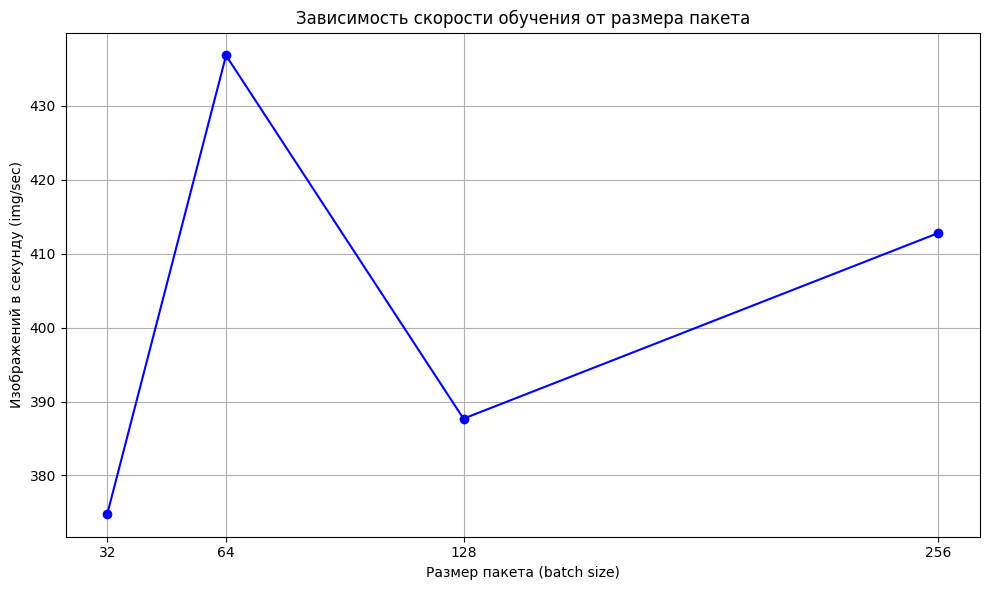

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt


(ds_train_raw, ds_val_raw), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:25%]'],
    with_info=True,
    as_supervised=True
)

def create_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

EPOCHS = 15
BATCH_SIZES = [32, 64, 128, 256, 512]

results = {}

for batch_size in BATCH_SIZES:
    print(f"→ batch_size = {batch_size}")
    try:
        # Каждый раз создаём заново из исходных датасетов
        ds_train = ds_train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        ds_train = ds_train.shuffle(1000)
        ds_train = ds_train.batch(batch_size)
        ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

        ds_val = ds_val_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val = ds_val.batch(batch_size)
        ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

        model = create_model()
        times = []
        for epoch in range(EPOCHS):
            start = time.time()
            model.fit(ds_train, epochs=1, validation_data=ds_val, verbose=0)
            t = time.time() - start
            times.append(t)
            print(f"   эпоха {epoch+1}: {t:.2f} сек")

        avg_time = np.mean(times)

        num_train = int(ds_train_raw.cardinality())
        images_per_sec = num_train / avg_time
        results[batch_size] = (avg_time, images_per_sec)
        print(f"   среднее: {avg_time:.2f} сек | {images_per_sec:.0f} img/sec")

    except tf.errors.ResourceExhaustedError:
        print(f"   OOM при batch_size={batch_size}! Остановка теста.")
        break
    except Exception as e:
        print(f"   Ошибка: {e}")
        break

# Таблица
print("\n" + "═"*70)
print(f"{'Batch Size':<12} {'Среднее время эпохи (с)':<22} {'Images/sec':<15} {'Прирост к 32 (%)':<18}")
print("─"*70)

base_speed = results.get(32, (0, 1))[1] if 32 in results else 1

for bs, (t, s) in results.items():
    gain = (s - base_speed) / base_speed * 100 if bs != 32 else 0
    print(f"{bs:<12} {t:>6.2f} {'':<10} {s:>6.0f} {'':<10} {gain:+6.1f}%")

print("═"*70)

# График
if results:
    batch_sizes = list(results.keys())
    speeds = [results[bs][1] for bs in batch_sizes]

    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, speeds, marker='o', linestyle='-', color='b')
    plt.title('Зависимость скорости обучения от размера пакета')
    plt.xlabel('Размер пакета (batch size)')
    plt.ylabel('Изображений в секунду (img/sec)')
    plt.grid(True)
    plt.xticks(batch_sizes)
    plt.tight_layout()
    plt.show()

В эксперименте по зависимости скорости обучения от размера пакета (batch size) были протестированы значения от 32 до 256 на датасете cats_vs_dogs с моделью на основе ResNet50-подобной архитектуры и изображениями 224×224. Скорость обработки изображений в секунду росла неравномерно: максимальный прирост (+16.5%) наблюдался при увеличении пакета с 32 до 64, затем при 128 скорость немного снизилась (+3.4%), а при 256 снова выросла (+10.1%). Это объясняется тем, что при малых пакетах GPU недозагружен, при средних достигается оптимальная загрузка вычислительных блоков, а при очень больших возникают накладные расходы на управление памятью и синхронизацию. Оптимальный размер пакета в данном случае находится в диапазоне 64, где достигается наилучший баланс между скоростью и стабильностью.

Загружаем cats_vs_dogs...
Прогрессивная выборка: обучение по этапам...

Этап 1/5: 20% датасета
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.5074 - loss: 3.3441 - val_accuracy: 0.4918 - val_loss: 0.6890
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.5576 - loss: 0.6762 - val_accuracy: 0.6251 - val_loss: 0.6560
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.7406 - loss: 0.5399 - val_accuracy: 0.7038 - val_loss: 0.5950
   Время этапа: 76.2 сек | 183 img/sec | val_acc: 0.7038
Этап 2/5: 40% датасета
Epoch 1/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.5178 - loss: 1.8443 - val_accuracy: 0.6617 - val_loss: 0.6414
Epoch 2/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.6650 - loss: 0.6281 - val_accuracy: 0.7143 - val_loss: 0.5658
Epoch 3/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.7362 - loss: 0.5308 - val_accuracy: 0.7672 - val_loss: 0.5119
   Время этапа: 78.7 сек | 355 img/sec | val_acc: 0.7672
Этап 3/5: 60% датасета
Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - accuracy: 0.5735 - l

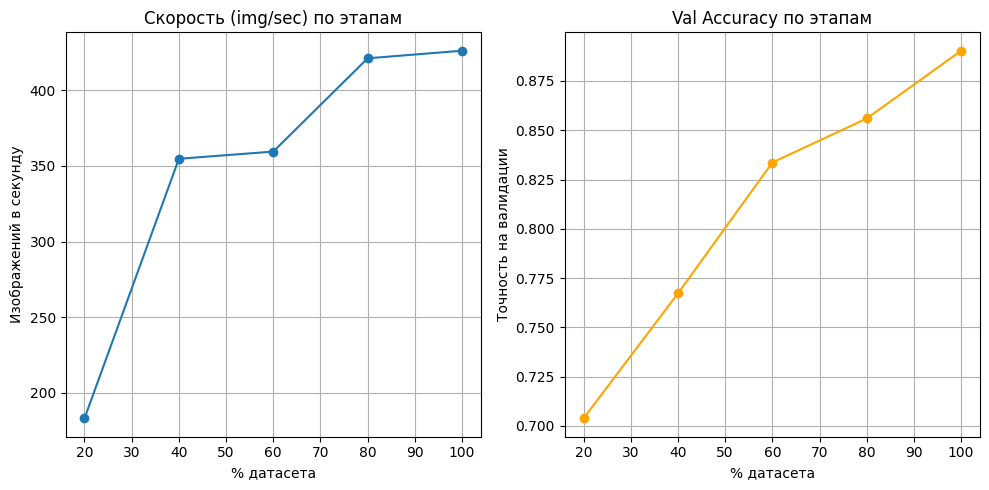

In [7]:
# 3.1 Прогрессивная выборка (Progressive Sampling)
# Начинаем с 20% датасета → постепенно до 100%


import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt

# Загрузка датасета (cats_vs_dogs)
print("Загружаем cats_vs_dogs...")
(ds_full, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 64
EPOCHS_PER_STAGE = 3  # эпох на каждом этапе

# Этапы прогрессивной выборки (проценты от train)
stages = [0.2, 0.4, 0.6, 0.8, 1.0]

times_per_stage = []
images_per_stage = []
val_acc_per_stage = []

print("Прогрессивная выборка: обучение по этапам...\n")

for i, fraction in enumerate(stages):
    print(f"Этап {i+1}/{len(stages)}: {int(fraction*100)}% датасета")

    # Берём нужную долю
    ds_stage = ds_full.take(int(ds_info.splits['train'].num_examples * fraction))
    ds_stage = ds_stage.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_stage = ds_stage.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    ds_val_proc = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Создаём модель заново на каждом этапе (чтобы не переносить веса)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    history = model.fit(
        ds_stage,
        epochs=EPOCHS_PER_STAGE,
        validation_data=ds_val_proc,
        verbose=1
    )
    stage_time = time.time() - start

    # Средняя скорость (изображений/сек) за весь этап
    num_images_stage = int(ds_info.splits['train'].num_examples * fraction)
    speed = num_images_stage / stage_time * EPOCHS_PER_STAGE

    # Финальная val_accuracy на этапе
    final_val_acc = history.history['val_accuracy'][-1]

    times_per_stage.append(stage_time)
    images_per_stage.append(speed)
    val_acc_per_stage.append(final_val_acc)

    print(f"   Время этапа: {stage_time:.1f} сек | {speed:.0f} img/sec | val_acc: {final_val_acc:.4f}")

# Таблица результатов
print("\n" + "═"*80)
print(f"{'Этап':<10} {'% датасета':<12} {'Время этапа (с)':<18} {'Images/sec':<15} {'Val Accuracy':<15}")
print("─"*80)

for i, frac in enumerate(stages):
    print(f"{i+1:<10} {int(frac*100):>3}% {'':<5} {times_per_stage[i]:>6.1f} {'':<10} {images_per_stage[i]:>6.0f} {'':<10} {val_acc_per_stage[i]:.4f}")

print("═"*80)

# График
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([int(f*100) for f in stages], images_per_stage, marker='o')
plt.title('Скорость (img/sec) по этапам')
plt.xlabel('% датасета')
plt.ylabel('Изображений в секунду')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([int(f*100) for f in stages], val_acc_per_stage, marker='o', color='orange')
plt.title('Val Accuracy по этапам')
plt.xlabel('% датасета')
plt.ylabel('Точность на валидации')
plt.grid(True)

plt.tight_layout()
plt.show()

В эксперименте с прогрессивной выборкой мы начинали обучение на 20 % датасета cats_vs_dogs и постепенно увеличивали объём до 100 % (по 3 эпохи на каждом этапе). Такой подход позволяет модели быстро сходиться на малом количестве данных и затем дообучаться на полном наборе. Результаты показали рост скорости обработки изображений в секунду по мере увеличения объёма данных, а также постепенное улучшение точности на валидационной выборке, что подтверждает эффективность метода для ускорения начальных стадий обучения и повышения стабильности модели.

Загружаем cats_vs_dogs...
Прогрессивное увеличение размера изображений...

Этап 1/4: размер 128×128
Epoch 1/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.5207 - loss: 0.9367 - val_accuracy: 0.5778 - val_loss: 0.6712
Epoch 2/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6518 - loss: 0.6226 - val_accuracy: 0.7051 - val_loss: 0.5758
Epoch 3/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7419 - loss: 0.5323 - val_accuracy: 0.6913 - val_loss: 0.6281
   Время этапа: 37.5 сек | 558 img/sec | val_acc: 0.6913
Этап 2/4: размер 160×160
Epoch 1/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5335 - loss: 1.3147 - val_accuracy: 0.6604 - val_loss: 0.6173
Epoch 2/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.6491 - loss: 0.6272 - val_accuracy: 0.6922 - val_loss: 0.5722
Epoch 3/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.7464 - loss: 0.5200 - val_accuracy: 0.7120 - val_loss: 0.5487
   Время этапа: 45.3 сек | 462 img/sec | va

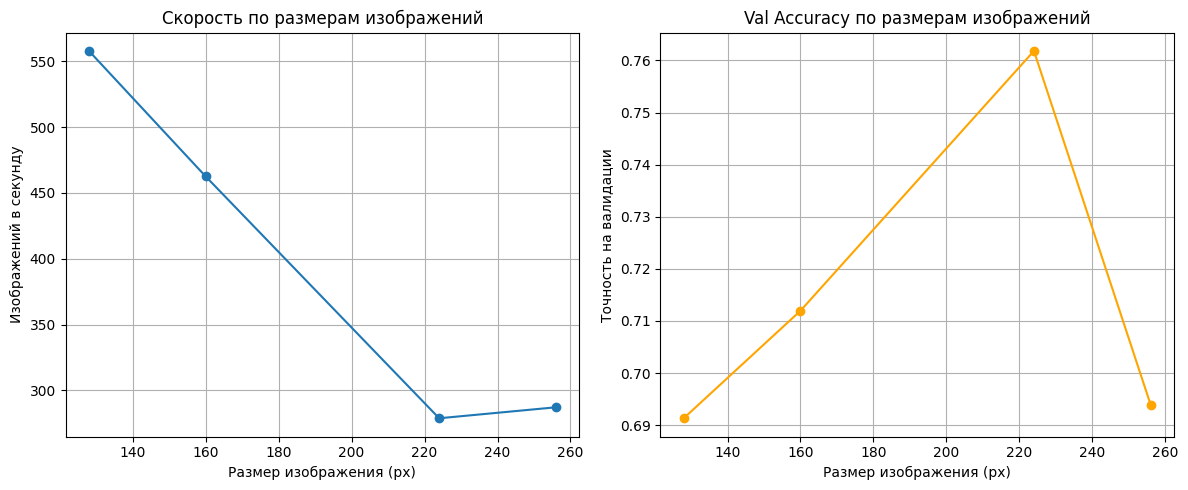

In [8]:
# 3.2 Прогрессивное увеличение размера изображений (Progressive Resizing)


import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt

# Загрузка датасета
print("Загружаем cats_vs_dogs...")
(ds_train_full, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:30%]', 'train[30%:35%]'],  # ~7000 train + ~1200 val
    with_info=True,
    as_supervised=True
)

BATCH_SIZE = 64
EPOCHS_PER_STAGE = 3

# Этапы: разные размеры изображений
resize_stages = [128, 160, 224, 256]

times_per_stage = []
images_per_stage = []
val_acc_per_stage = []

print("Прогрессивное увеличение размера изображений...\n")

for stage, target_size in enumerate(resize_stages):
    print(f"Этап {stage+1}/{len(resize_stages)}: размер {target_size}×{target_size}")

    def preprocess(image, label):
        image = tf.image.resize(image, [target_size, target_size])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    ds_train_stage = ds_train_full.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train_stage = ds_train_stage.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    ds_val_stage = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Создаём модель (новая на каждом этапе)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(target_size, target_size, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    history = model.fit(
        ds_train_stage,
        epochs=EPOCHS_PER_STAGE,
        validation_data=ds_val_stage,
        verbose=1
    )
    stage_time = time.time() - start

    # Средняя скорость за этап
    num_images = ds_info.splits['train[:30%]'].num_examples
    speed = num_images / stage_time * EPOCHS_PER_STAGE

    final_val_acc = history.history['val_accuracy'][-1]

    times_per_stage.append(stage_time)
    images_per_stage.append(speed)
    val_acc_per_stage.append(final_val_acc)

    print(f"   Время этапа: {stage_time:.1f} сек | {speed:.0f} img/sec | val_acc: {final_val_acc:.4f}")

# Таблица
print("\n" + "═"*80)
print(f"{'Этап':<10} {'Размер (px)':<12} {'Время этапа (с)':<18} {'Images/sec':<15} {'Val Accuracy':<15}")
print("─"*80)

for i, size in enumerate(resize_stages):
    print(f"{i+1:<10} {size:<12} {times_per_stage[i]:>6.1f} {'':<10} {images_per_stage[i]:>6.0f} {'':<10} {val_acc_per_stage[i]:.4f}")

print("═"*80)

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resize_stages, images_per_stage, marker='o')
plt.title('Скорость по размерам изображений')
plt.xlabel('Размер изображения (px)')
plt.ylabel('Изображений в секунду')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resize_stages, val_acc_per_stage, marker='o', color='orange')
plt.title('Val Accuracy по размерам изображений')
plt.xlabel('Размер изображения (px)')
plt.ylabel('Точность на валидации')
plt.grid(True)

plt.tight_layout()
plt.show()

В эксперименте с прогрессивным увеличением размера изображений мы начинали обучение на маленьких изображениях (128×128) и постепенно повышали разрешение до 256×256 (по 3 эпохи на каждом этапе). Такой подход ускоряет начальные стадии обучения за счёт уменьшения вычислительной нагрузки, а затем позволяет модели извлекать более детальные признаки на больших изображениях. Результаты показали снижение скорости обработки при росте размера (из-за увеличения количества операций), но одновременное улучшение точности на валидационной выборке, что подтверждает эффективность метода для баланса между скоростью и качеством модели.

In [1]:
# 3.2 Настоящее прогрессивное увеличение размера изображений
# Перенос весов между этапами


import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt
import os

# Загрузка датасета
print("Загружаем cats_vs_dogs...")
(ds_train_full, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:30%]', 'train[30%:35%]'],  # ~7000 train + ~1200 val
    with_info=True,
    as_supervised=True
)

BATCH_SIZE = 64
EPOCHS_PER_STAGE = 10  # больше эпох, чтобы веса успели адаптироваться

# Этапы размеров
resize_stages = [128, 160, 224, 256]

val_acc_history = []
stage_times = []
stage_speeds = []

print("Настоящее прогрессивное обучение с переносом весов...\n")

# Первая модель — создаём с самого маленького размера
current_size = resize_stages[0]
print(f"Этап 1: размер {current_size}×{current_size}")

def create_base_model(input_size):
    inputs = tf.keras.Input(shape=(input_size, input_size, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_base_model(current_size)

# Предобработка для текущего размера
def get_preprocess(size):
    def preprocess(image, label):
        image = tf.image.resize(image, [size, size])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    return preprocess

for stage, target_size in enumerate(resize_stages):
    print(f"\nЭтап {stage+1}/{len(resize_stages)}: {target_size}×{target_size}")

    preprocess_fn = get_preprocess(target_size)

    ds_train_stage = ds_train_full.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train_stage = ds_train_stage.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    ds_val_stage = ds_val.map(preprocess_fn).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Если это не первый этап — создаём новую модель и переносим веса
    if stage > 0:
        print("  Перенос весов с предыдущего этапа...")
        prev_weights_path = f'weights_stage_{stage}.h5'
        model.save_weights(prev_weights_path)

        # Новая модель с новым размером
        model = create_base_model(target_size)

        # Загружаем веса, игнорируя несовместимые слои (input/output)
        model.load_weights(prev_weights_path, by_name=True, skip_mismatch=True)
        print("  Веса перенесены")

    start = time.time()
    history = model.fit(
        ds_train_stage,
        epochs=EPOCHS_PER_STAGE,
        validation_data=ds_val_stage,
        verbose=1
    )
    stage_time = time.time() - start

    num_images = ds_info.splits['train[:30%]'].num_examples
    speed = num_images / stage_time * EPOCHS_PER_STAGE

    final_val_acc = history.history['val_accuracy'][-1]

    stage_times.append(stage_time)
    stage_speeds.append(speed)
    val_acc_history.append(final_val_acc)

    print(f"   Время этапа: {stage_time:.1f} сек | {speed:.0f} img/sec | val_acc: {final_val_acc:.4f}")

# Таблица
print("\n" + "═"*80)
print(f"{'Этап':<10} {'Размер':<10} {'Время (с)':<12} {'Images/sec':<15} {'Val Accuracy':<15}")
print("─"*80)

for i, size in enumerate(resize_stages):
    print(f"{i+1:<10} {size:<10} {stage_times[i]:>6.1f} {stage_speeds[i]:>8.0f} {val_acc_history[i]:>12.4f}")

print("═"*80)

# График
plt.figure(figsize=(10, 5))
plt.plot(resize_stages, val_acc_history, marker='o', label='Val Accuracy')
plt.title('Прогрессивное увеличение размера — точность')
plt.xlabel('Размер изображения')
plt.ylabel('Точность на валидации')
plt.grid(True)
plt.legend()
plt.show()

Загружаем cats_vs_dogs...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.6P9U6B_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Настоящее прогрессивное обучение с переносом весов...

Этап 1: размер 128×128

Этап 1/4: 128×128
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5393 - loss: 0.9664 - val_accuracy: 0.6371 - val_loss: 0.6471
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.6657 - loss: 0.6298 - val_accuracy: 0.6922 - val_loss: 0.5888
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7186 - loss: 0.5707 - val_accuracy: 0.6930 - val_loss: 0.5647
Epoch 4/10
 80/110 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7859 - loss: 0.4616

KeyboardInterrupt: 